# Predicting air temperatures from LST

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import zipfile
import os
import rasterio
import requests
import tempfile
import shutil
from rasterio.warp import transform
from pyproj import Transformer
from zipfile import ZipFile
from datetime import datetime, timedelta
from shapely.geometry import Point
import hvplot.pandas
from shapely.geometry import box
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

## Data Preparation

Filtering low cloud cover scenes across time (<= 10%)

In [3]:
# List of zip file paths for metadata
zip_file_paths_metadata = [
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat5\L5_Metadata.zip",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat7\L7_Metadata.zip",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat8\L8_Metadata.zip",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat9\L9_Metadata.zip"
]

def filtering_cc(zip_file_paths_metadata, cloud_cover):
    # List to store dates and times of low cloud cover images
    low_cloud_cover_dates = []

    # Process each zip file
    for zip_file_path in zip_file_paths_metadata:
        with zipfile.ZipFile(zip_file_path, 'r') as z:
            # List all contained files that end with .csv
            csv_files = [f for f in z.namelist() if f.endswith('.csv')]
            
            # Process each CSV file
            for csv_file in csv_files:
                with z.open(csv_file) as f:
                    # Read the file into a pandas DataFrame
                    df = pd.read_csv(f)
                    
                    # Filter data where CLOUD_COVER <= cloud_cover
                    if df['CLOUD_COVER'].iloc[0] <= cloud_cover:
                        # Extract the date and time from the file name
                        date_time = os.path.basename(csv_file).split('_')[2] + '_' + os.path.basename(csv_file).split('_')[3].split('.')[0]
                        low_cloud_cover_dates.append(date_time)

    # Print or return the dates for further processing
    print("Dates with cloud cover <= " + str(cloud_cover) + "%:")
    for date_time in low_cloud_cover_dates:
        print(date_time)

    return low_cloud_cover_dates

In [4]:
cc10_dates = filtering_cc(zip_file_paths_metadata, 10)

Dates with cloud cover <= 10%:
20050504_030351
19990621_025432
19910615_023926
19900831_023629
19920719_023935
20220901_013952
20220608_014623
20211116_020826
20210217_023142
20180209_031812
20060429_030640
20050410_030614
20000428_030856
20230522_031555
20231013_031648
20180508_031543
20180524_031532
20140513_031612
20240313_031647


Merging air temperature data at weather stations with weather station metadata (i.e. longitude/latitude coordinates)

In [5]:
# Filtering date and time specific air temperature data
dates_to_filter_utc = [datetime.strptime(date, "%Y%m%d_%H%M%S") for date in cc10_dates if int(date[:4]) >= 2016]
dates_to_filter_gmt8 = [datetime.strptime(date, "%Y%m%d_%H%M%S") + timedelta(hours=8) for date in cc10_dates if int(date[:4]) >= 2016]

def fetch_station_data(dates):
    base_path = r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature"
    station_details = pd.DataFrame()

    # Process each date
    for date in dates:
        year = date.strftime('%Y')
        file_path = f"{base_path}\AirTemperature_{year}.csv"

        try:
            # Read the CSV file for the year
            df = pd.read_csv(file_path)
            # Format the 'timestamp' for filtering
            filter_str = date.strftime('%Y-%m-%dT%H:%M')
            filtered_df = df[df['timestamp'].astype(str).apply(lambda x: x.startswith(filter_str))]
            if not filtered_df.empty:
                station_details = pd.concat([station_details, filtered_df])
                print(filtered_df)
        except FileNotFoundError:
            print(f"No file found for the year {year}")

    return station_details

# Get the filtered data
filtered_station_data = fetch_station_data(dates_to_filter_gmt8)
print(filtered_station_data)

# filtered_station_data.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\AirTemperature_cc10.csv", index=False)

                         timestamp station_id  temperature
4720043  2022-09-01T09:39:00+08:00       S109         30.6
4720044  2022-09-01T09:39:00+08:00        S50         29.0
4720045  2022-09-01T09:39:00+08:00       S107         29.3
4720046  2022-09-01T09:39:00+08:00        S43         29.9
4720047  2022-09-01T09:39:00+08:00       S108         30.6
4720048  2022-09-01T09:39:00+08:00        S44         30.0
4720049  2022-09-01T09:39:00+08:00       S121         30.2
4720050  2022-09-01T09:39:00+08:00       S106         30.7
4720051  2022-09-01T09:39:00+08:00       S111         30.1
4720052  2022-09-01T09:39:00+08:00        S60         29.7
4720053  2022-09-01T09:39:00+08:00       S115         28.6
4720054  2022-09-01T09:39:00+08:00        S24         29.9
4720055  2022-09-01T09:39:00+08:00       S116         30.0
4720056  2022-09-01T09:39:00+08:00       S104         29.1
4720057  2022-09-01T09:39:00+08:00       S100         30.4
                         timestamp station_id  temperatu

In [6]:
# Define the base URL for the API
base_url = "https://api.data.gov.sg/v1/environment/air-temperature"

def fetch_station_metadata(dates):
    """Fetches metadata for weather stations on specific dates and ensures unique station entries."""
    station_dict = {}  # Using a dictionary to avoid duplicate station entries

    for date_obj in dates:
        # Format date object to the required string format for API request
        date_str = date_obj.strftime('%Y-%m-%d')
        response = requests.get(f"{base_url}?date={date_str}")
        if response.status_code == 200:
            data = response.json()
            stations = data['metadata']['stations']
            for station in stations:
                station_id = station['id']
                if station_id not in station_dict:
                    # Only add new station details if not already in dictionary
                    station_dict[station_id] = {
                        'station_id': station['device_id'],
                        'name': station['name'],
                        'longitude': station['location']['longitude'],
                        'latitude': station['location']['latitude']
                    }
            print("Station metadata fetched for " + date_str)
        else:
            print(f"Failed to fetch data for {date_str}")

    # Convert dictionary to DataFrame for easy handling and viewing
    return pd.DataFrame.from_dict(station_dict, orient='index')

# Example usage with the corrected dates_to_filter list
station_metadata = fetch_station_metadata(dates_to_filter_gmt8)
print(station_metadata)

# station_metadata.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\StationMetadata_cc10.csv", index=False)

Station metadata fetched for 2022-09-01
Station metadata fetched for 2022-06-08
Station metadata fetched for 2021-11-16
Station metadata fetched for 2021-02-17
Station metadata fetched for 2018-02-09
Station metadata fetched for 2023-05-22
Station metadata fetched for 2023-10-13
Station metadata fetched for 2018-05-08
Station metadata fetched for 2018-05-24
Station metadata fetched for 2024-03-13
     station_id                     name  longitude  latitude
S109       S109      Ang Mo Kio Avenue 5  103.84920   1.37640
S50         S50            Clementi Road  103.77680   1.33370
S107       S107       East Coast Parkway  103.96250   1.31350
S43         S43           Kim Chuan Road  103.88780   1.33990
S108       S108     Marina Gardens Drive  103.87030   1.27990
S44         S44           Nanyang Avenue  103.68166   1.34583
S121       S121   Old Choa Chu Kang Road  103.72244   1.37288
S106       S106               Pulau Ubin  103.96730   1.41680
S111       S111              Scotts Road  

In [17]:
def preparing_air_temps_cc10_gdf(filtered_station_data, station_metadata):
    air_temps_cc10 = filtered_station_data.merge(station_metadata, on='station_id', how='left')

    air_temps_cc10_gdf = gpd.GeoDataFrame(air_temps_cc10, geometry=gpd.points_from_xy(air_temps_cc10.longitude, air_temps_cc10.latitude))

    air_temps_cc10_gdf['timestamp_datetime'] = pd.to_datetime(air_temps_cc10_gdf['timestamp'])
    air_temps_cc10_gdf['time'] = air_temps_cc10_gdf['timestamp_datetime'].dt.strftime('%Y-%m-%d')

    if air_temps_cc10_gdf.crs is None:
        air_temps_cc10_gdf = air_temps_cc10_gdf.set_crs('EPSG:4326')

    air_temps_cc10_gdf = air_temps_cc10_gdf.to_crs('EPSG:3857')

    return air_temps_cc10_gdf

air_temps_cc10_gdf = preparing_air_temps_cc10_gdf(filtered_station_data, station_metadata)

air_temps_cc10_gdf.head()

,timestamp,station_id,temperature,name,longitude,latitude,geometry,timestamp_datetime,time
0,2022-09-01T09:39:00+08:00,S109,30.6,Ang Mo Kio Avenue 5,103.8492,1.3764,POINT (11560440.063 153234.886),2022-09-01 09:39:00+08:00,2022-09-01
1,2022-09-01T09:39:00+08:00,S50,29.0,Clementi Road,103.7768,1.3337,POINT (11552380.532 148480.214),2022-09-01 09:39:00+08:00,2022-09-01
2,2022-09-01T09:39:00+08:00,S107,29.3,East Coast Parkway,103.9625,1.3135,POINT (11573052.562 146230.960),2022-09-01 09:39:00+08:00,2022-09-01
3,2022-09-01T09:39:00+08:00,S43,29.9,Kim Chuan Road,103.8878,1.3399,POINT (11564736.996 149170.583),2022-09-01 09:39:00+08:00,2022-09-01
4,2022-09-01T09:39:00+08:00,S108,30.6,Marina Gardens Drive,103.8703,1.2799,POINT (11562788.905 142489.667),2022-09-01 09:39:00+08:00,2022-09-01


Filtering pixels at specific weather station locations for all dates with cloud cover <= 10%

In [16]:
singapore_geojson_path = "C:\\LocalOneDrive\\Documents\\Desktop\\MTI\\UHI-Project\\MSE-ES-UHI\\Data\\singapore-boundary.geojson"
singapore_boundary = gpd.read_file(singapore_geojson_path)
singapore_boundary = singapore_boundary.set_crs('EPSG:4326')
singapore_boundary = singapore_boundary.to_crs('EPSG:3857')

singapore_boundary

,geometry
0,"MULTIPOLYGON (((11533294.805 138488.988, 11533..."


In [72]:
# List of zip file paths for Landsat data
zip_file_paths = [
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat8",
    r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\Landsat9"
]

In [74]:
# Landsat images -> tabular format -> EPSG:3857 coordinates system -> Singapore boundaries -> filter pixels at specific weather stations

def process_landsat_data(date_str, zip_file_paths, singapore_boundary, air_temps_gdf):
    year = date_str[:4]
    data_list = []
    date_obj = datetime.strptime(date_str, "%Y%m%d_%H%M%S")
    formatted_date_str = date_obj.strftime('%Y-%m-%d')

    for path in zip_file_paths:
        zip_filename = f"{year}.zip"
        zip_filepath = os.path.join(path, zip_filename)
        
        if os.path.exists(zip_filepath):
            with ZipFile(zip_filepath, 'r') as z:
                tif_files = [f for f in z.namelist() if f.endswith('.tif') and date_str in f]
                print(tif_files)
                for tif_file in tif_files:
                    temp_dir = tempfile.mkdtemp()
                    z.extract(tif_file, temp_dir)
                    tif_path = os.path.join(temp_dir, tif_file)
                    
                    with rasterio.open(tif_path) as src:
                        array = src.read()  # Read all bands
                        transform = src.transform
                        src_crs = src.crs  # Source CRS
                        dest_crs = 'EPSG:3857'  # Target CRS

                        transformer = Transformer.from_crs(src_crs, dest_crs, always_xy=True)

                        cols, rows = np.meshgrid(np.arange(array.shape[2]), np.arange(array.shape[1]))
                        xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

                        lon, lat = transformer.transform(np.array(xs).flatten(), np.array(ys).flatten())
                        df = pd.DataFrame({'Longitude': lon, 'Latitude': lat})
                        
                        for i, band in enumerate(src.read(masked=True)):
                            df[src.descriptions[i] if src.descriptions[i] else f"band_{i+1}"] = band.flatten()

                        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
                        gdf.set_crs(dest_crs, inplace=True)
                        gdf = gpd.sjoin(gdf, singapore_boundary, how="inner", predicate='within')

                        # print("Number of pixels in Singapore's boundaries: " + str(len(gdf)))
                        # print(gdf)

                        # Create 30m x 30m boxes around each point
                        gdf['geometry'] = gdf['geometry'].apply(
                            lambda p: box(p.x - 15, p.y - 15, p.x + 15, p.y + 15)
                        )
                        print("30m by 30m pixels created for " + formatted_date_str + ". Conducting spatial join...")
                        gdf = gdf.drop('index_right', axis=1)

                        joined_gdf = gpd.sjoin(air_temps_gdf[air_temps_gdf['time'] == formatted_date_str], gdf, how="left", predicate='intersects')

                        # print("Length of joined GeoDataFrame: " + str(len(joined_gdf)))
                        # print(joined_gdf)

                        data_list.append(joined_gdf)

                    shutil.rmtree(temp_dir)

                    return joined_gdf

air_temps_pixels_gdf = gpd.GeoDataFrame()

for date in dates_to_filter_utc:
    date_str = date.strftime('%Y%m%d_%H%M%S')
    gdf = process_landsat_data(date_str, zip_file_paths, singapore_boundary, air_temps_cc10_gdf)
    if gdf is not None:
        print(gdf)
        air_temps_pixels_gdf = pd.concat([air_temps_pixels_gdf, gdf], ignore_index=True)
        print("Finished processing Landsat scene on " + date_str)
        # print(gdf.head())
    else:
        print(f"No GeoDataFrame returned for {date_str}")

[]
[]
No GeoDataFrame returned for 20220901_013952
[]
[]
No GeoDataFrame returned for 20220608_014623
[]
[]
No GeoDataFrame returned for 20211116_020826
[]
[]
No GeoDataFrame returned for 20210217_023142
[]
No GeoDataFrame returned for 20180209_031812
['2023/L8_UTC_20230522_031555.tif']
30m by 30m pixels created for 2023-05-22. Conducting spatial join...
                    timestamp station_id  temperature  \
72  2023-05-22T11:15:00+08:00       S109         31.4   
73  2023-05-22T11:15:00+08:00       S117         30.4   
74  2023-05-22T11:15:00+08:00        S50         31.0   
75  2023-05-22T11:15:00+08:00       S107         30.0   
76  2023-05-22T11:15:00+08:00        S43         31.2   
77  2023-05-22T11:15:00+08:00        S44         31.1   
78  2023-05-22T11:15:00+08:00       S121         31.9   
79  2023-05-22T11:15:00+08:00       S106         32.2   
80  2023-05-22T11:15:00+08:00       S111         29.3   
81  2023-05-22T11:15:00+08:00        S60         30.1   
82  2023-05-22T1

## Training Machine Learning Model

In [78]:
air_temps_pixels_gdf.to_csv(r"C:\LocalOneDrive\Documents\Desktop\MTI\UHI-Project\MSE-ES-UHI\Data\WeatherReadings\AirTemperature\air_temps_pixels_cc10_l8_9.csv", index=False)

air_temps_pixels_gdf.rename(columns={'temperature': 'AirTemp'}, inplace=True)

In [79]:
def preprocessing_model_data(cc10_pixels_air_temps_gdf):
    # Scaling bands and creating bands for model training and prediction (eg. LST, NDVI, NDBI)

    # Calculate LST for available columns
    cc10_pixels_air_temps_gdf['ST_B10_Celsius'] = cc10_pixels_air_temps_gdf['ST_B10'] * 0.00341802 + 149 - 273.15

    # Scale and offset values for SR_B4 (Near Infrared) and SR_B5 (Shortwave Infrared 1)
    scale = 2.75e-05
    offset = -0.2

    # Apply scale and offset to the bands
    cc10_pixels_air_temps_gdf['SR_B1_Scaled'] = (cc10_pixels_air_temps_gdf['SR_B1'] * scale) + offset
    cc10_pixels_air_temps_gdf['SR_B2_Scaled'] = (cc10_pixels_air_temps_gdf['SR_B2'] * scale) + offset
    cc10_pixels_air_temps_gdf['SR_B3_Scaled'] = (cc10_pixels_air_temps_gdf['SR_B3'] * scale) + offset
    cc10_pixels_air_temps_gdf['SR_B4_Scaled'] = (cc10_pixels_air_temps_gdf['SR_B4'] * scale) + offset
    cc10_pixels_air_temps_gdf['SR_B5_Scaled'] = (cc10_pixels_air_temps_gdf['SR_B5'] * scale) + offset
    cc10_pixels_air_temps_gdf['SR_B6_Scaled'] = (cc10_pixels_air_temps_gdf['SR_B6'] * scale) + offset
    cc10_pixels_air_temps_gdf['SR_B7_Scaled'] = (cc10_pixels_air_temps_gdf['SR_B7'] * scale) + offset

    cc10_pixels_air_temps_gdf['ST_URAD_Scaled'] = (cc10_pixels_air_temps_gdf['ST_URAD'] * 0.001)
    cc10_pixels_air_temps_gdf['ST_DRAD_Scaled'] = (cc10_pixels_air_temps_gdf['ST_DRAD'] * 0.001)
    cc10_pixels_air_temps_gdf['ST_ATRAN_Scaled'] = (cc10_pixels_air_temps_gdf['ST_ATRAN'] * 0.0001)
    cc10_pixels_air_temps_gdf['ST_CDIST_Scaled'] = (cc10_pixels_air_temps_gdf['ST_CDIST'] * 0.01)
    cc10_pixels_air_temps_gdf['ST_EMIS_Scaled'] = (cc10_pixels_air_temps_gdf['ST_EMIS'] * 0.0001)
    cc10_pixels_air_temps_gdf['ST_EMSD_Scaled'] = (cc10_pixels_air_temps_gdf['ST_EMSD'] * 0.0001)


    # NDVI
    cc10_pixels_air_temps_gdf['NDVI'] = (cc10_pixels_air_temps_gdf['SR_B5_Scaled'] - cc10_pixels_air_temps_gdf['SR_B4_Scaled']) / (cc10_pixels_air_temps_gdf['SR_B5_Scaled'] + cc10_pixels_air_temps_gdf['SR_B4_Scaled'])

    # NBDI
    cc10_pixels_air_temps_gdf['NDBI'] = (cc10_pixels_air_temps_gdf['SR_B6_Scaled'] - cc10_pixels_air_temps_gdf['SR_B5_Scaled']) / (cc10_pixels_air_temps_gdf['SR_B6_Scaled'] + cc10_pixels_air_temps_gdf['SR_B5_Scaled'])

    # Surface Albedo
    cc10_pixels_air_temps_gdf['Albedo'] = (0.356*cc10_pixels_air_temps_gdf['SR_B2_Scaled'] + 0.130*cc10_pixels_air_temps_gdf['SR_B4_Scaled'] 
                                               + 0.373*cc10_pixels_air_temps_gdf['SR_B5_Scaled'] + 0.085*cc10_pixels_air_temps_gdf['SR_B6_Scaled'] 
                                               + 0.072*cc10_pixels_air_temps_gdf['SR_B7_Scaled'] - 0.0018)
    
    print(cc10_pixels_air_temps_gdf.head())

    return cc10_pixels_air_temps_gdf

In [80]:
air_temps_pixels_gdf = preprocessing_model_data(air_temps_pixels_gdf)

                   timestamp station_id  AirTemp                 name  \
0  2023-05-22T11:15:00+08:00       S109     31.4  Ang Mo Kio Avenue 5   
1  2023-05-22T11:15:00+08:00       S117     30.4          Banyan Road   
2  2023-05-22T11:15:00+08:00        S50     31.0        Clementi Road   
3  2023-05-22T11:15:00+08:00       S107     30.0   East Coast Parkway   
4  2023-05-22T11:15:00+08:00        S43     31.2       Kim Chuan Road   

   longitude  latitude                         geometry  \
0   103.8492    1.3764  POINT (11560440.063 153234.886)   
1   103.6790    1.2560  POINT (11541493.486 139828.480)   
2   103.7768    1.3337  POINT (11552380.532 148480.214)   
3   103.9625    1.3135  POINT (11573052.562 146230.960)   
4   103.8878    1.3399  POINT (11564736.996 149170.583)   

         timestamp_datetime        time  index_right  ...  SR_B7_Scaled  \
0 2023-05-22 11:15:00+08:00  2023-05-22     617534.0  ...      0.099970   
1 2023-05-22 11:15:00+08:00  2023-05-22    1406329.0  ..

In [81]:
air_temps_pixels_gdf.columns

Index(['timestamp', 'station_id', 'AirTemp', 'name', 'longitude', 'latitude',
       'geometry', 'timestamp_datetime', 'time', 'index_right', 'Longitude',
       'Latitude', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6',
       'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD',
       'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL',
       'QA_RADSAT', 'ST_B10_Celsius', 'SR_B1_Scaled', 'SR_B2_Scaled',
       'SR_B3_Scaled', 'SR_B4_Scaled', 'SR_B5_Scaled', 'SR_B6_Scaled',
       'SR_B7_Scaled', 'ST_URAD_Scaled', 'ST_DRAD_Scaled', 'ST_ATRAN_Scaled',
       'ST_CDIST_Scaled', 'ST_EMIS_Scaled', 'ST_EMSD_Scaled', 'NDVI', 'NDBI',
       'Albedo'],
      dtype='object')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


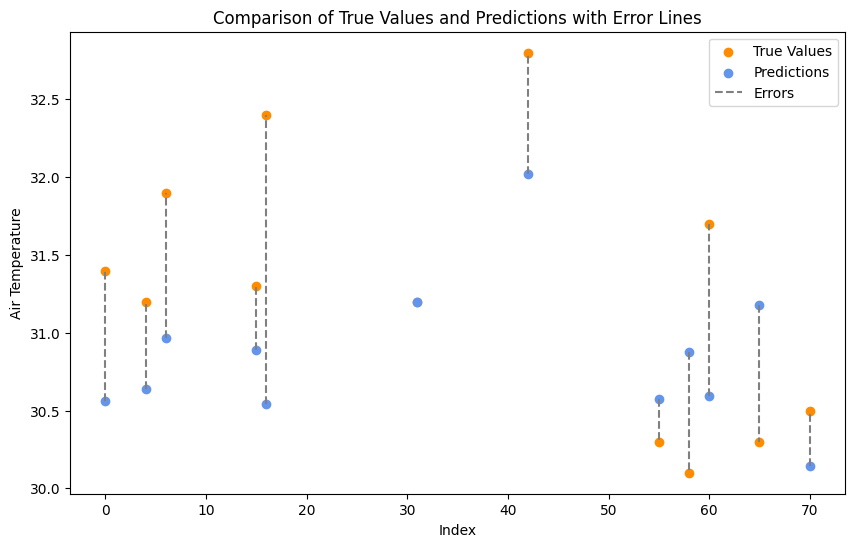


Best model parameters: {'svr__epsilon': 0.4342857142857143, 'svr__C': 3.593813663804626}

Train R²: 0.7221648292601888 Test R²: -0.10517585106744898

Train MSE: 0.1767202738794381 Test MSE: 0.7431540115198668


In [202]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Define bands to drop
bands_to_drop = ['AirTemp', 'geometry', 'name', 'time', 'timestamp', 'station_id', 'longitude', 'latitude', 
                 'timestamp_datetime', 'index_right', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 
                 'SR_B7', 'ST_B10', 'QA_PIXEL', 'QA_RADSAT', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 
                 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_URAD', 'SR_QA_AEROSOL']

# Prepare data
X = air_temps_pixels_gdf.drop(bands_to_drop, axis=1)
y = air_temps_pixels_gdf['AirTemp']

# Handle NaNs in the dataset
X = X.dropna()
y = y.loc[X.index]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model pipeline
pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf'))

# Define parameter grid for RandomizedSearchCV
param_grid = {
    'svr__C': np.logspace(-1, 1, 10),
    'svr__epsilon': np.linspace(0.01, 1, 50)
}

# Setup for RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    verbose=3,
    scoring='neg_mean_squared_error',  # Specify to use negative MSE as the scoring function
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
search.fit(X_train, y_train)

# Find the best model
best_model = search.best_estimator_

# Predict using the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Plot the predicted values against the true values
plt.figure(figsize=(10, 6))
plt.scatter(X_test.index, y_test, color='darkorange', label='True Values')
plt.scatter(X_test.index, y_test_pred, color='cornflowerblue', label='Predictions')
plt.vlines(X_test.index, y_test_pred, y_test, colors='gray', linestyles='dashed', label='Errors')

plt.title('Comparison of True Values and Predictions with Error Lines')
plt.xlabel('Index')
plt.ylabel('Air Temperature')
plt.legend()
plt.show()

# Calculate and print evaluation metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\nBest model parameters:", search.best_params_)
print("\nTrain R²:", train_r2, "Test R²:", test_r2)
print("\nTrain MSE:", train_mse, "Test MSE:", test_mse)

In [195]:
# Parameters of Random Forest Regressor Model: https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/ 
# Reference literature/study: https://www.frontiersin.org/journals/environmental-science/articles/10.3389/fenvs.2021.791336/full 
# Hyperparameter tuning: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 

def random_forest(air_temps_pixels_gdf): # n_iter=10 and cv=5; test MSE=0.8127979236991412 
    # Define dropped bands and features
    bands_to_drop = ['AirTemp', 'geometry', 'name', 'time', 'timestamp', 'station_id', 'longitude', 'latitude', 'timestamp_datetime', 'index_right',
                     'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10',
                     'QA_PIXEL', 'QA_RADSAT', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_URAD', 'SR_QA_AEROSOL']
    X = air_temps_pixels_gdf.drop(bands_to_drop, axis=1)
    y = air_temps_pixels_gdf['AirTemp']

    # Handling NaNs in the dataset
    X = X.dropna()
    y = y.loc[X.index]

    if y.empty:
        print("Empty dataset after preprocessing. Check your data or preprocessing steps.")
        return None

    # Splitting the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Defining the parameter grid for RandomizedSearchCV
    # param_grid = {
    #     'n_estimators': [20, 25, 30],
    #     'max_depth': [5, 8, 10],
    #     'min_samples_split': [5, 8, 10],
    #     'min_samples_leaf': [5, 8, 10],
    #     'max_features': ['log2'],
    #     'max_leaf_nodes': [8, 10, 12],
    #     'max_samples': [0.4, 0.5, 0.6]
    # }

    # param_grid = {
    # 'n_estimators': [25, 50, 75],  # Increasing the range to include more possibilities for the number of trees
    # 'max_depth': [None, 5, 10, 15],  # Including None to allow trees to expand until all leaves are pure
    # 'min_samples_split': [2, 5, 10],  # Starting from a lower threshold to potentially increase model complexity
    # 'min_samples_leaf': [1, 3, 5],  # Starting from a lower number to capture finer detail in the data
    # 'max_features': ['log2'],  # Exploring different ways of selecting features at each split
    # 'max_leaf_nodes': [None, 10, 20, 30],  # Including None to remove the constraint on the number of leaf nodes
    # 'max_samples': [0.4, 0.5, 0.6]  # Adjusting the proportion of samples used for building each tree
    # }

    param_grid = {
        'n_estimators': [20, 30, 35],
        'max_depth': [5, 8, 10],
        'min_samples_split': [5, 8, 10],
        'min_samples_leaf': [3, 5, 8],
        'max_features': ['log2'],
        'max_leaf_nodes': [10, 12, 15],
        'max_samples': [0.5, 0.6, 0.7]
    }

    # Setup for RandomizedSearchCV
    rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   cv=3,
                                   verbose=3,  # Increased verbosity to see the progress more clearly
                                   random_state=42,
                                   n_jobs=-1)
    
    # Conducting k-fold cross validation ensures that the hyperparameter tuning does not overfit to this specific Landsat scene

    # Fitting RandomizedSearchCV
    rf_random.fit(X_train, y_train)

    # Finding the best model and predicting
    best_model = rf_random.best_estimator_

    # Output feature importances
    feature_importances = pd.DataFrame(best_model.feature_importances_,
                                       index = X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    print("\nFeature Importances:\n", feature_importances)

    # Predicting and evaluating
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Calculate scores
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Output results
    print("\nBest model parameters:", rf_random.best_params_)
    print("\nTrain R²:", train_r2, "Test R²:", test_r2)
    print("\nTrain MSE:", train_mse, "Test MSE:", test_mse)

    return best_model

In [196]:
# Ensure your data is loaded correctly before calling the function
rf_model = random_forest(air_temps_pixels_gdf)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Feature Importances:
                  importance
ST_EMIS_Scaled     0.200000
SR_B3_Scaled       0.133333
ST_B10_Celsius     0.100000
SR_B6_Scaled       0.100000
SR_B4_Scaled       0.066667
NDVI               0.066667
Latitude           0.066667
ST_URAD_Scaled     0.066667
ST_DRAD_Scaled     0.066667
NDBI               0.062634
SR_B2_Scaled       0.033333
ST_EMSD_Scaled     0.033333
ST_TRAD            0.004032
Longitude          0.000000
SR_B7_Scaled       0.000000
ST_CDIST_Scaled    0.000000
ST_ATRAN_Scaled    0.000000
SR_B5_Scaled       0.000000
SR_B1_Scaled       0.000000
Albedo             0.000000

Best model parameters: {'n_estimators': 30, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_samples': 0.6, 'max_leaf_nodes': 12, 'max_features': 'log2', 'max_depth': 5}

Train R²: 0.2090532210093573 Test R²: -0.1977088413440804

Train MSE: 0.5030908471202316 Test MSE: 0.8053760215787987


In [32]:
air_temps_pixels_gdf

,timestamp,station_id,temperature,name,longitude,latitude,geometry,timestamp_datetime,time,index_right,...,SR_B7_Scaled,ST_URAD_Scaled,ST_DRAD_Scaled,ST_ATRAN_Scaled,ST_CDIST_Scaled,ST_EMIS_Scaled,ST_EMSD_Scaled,NDVI,NDBI,Albedo
0,2022-09-01T09:39:00+08:00,S109,30.6,Ang Mo Kio Avenue 5,103.84920,1.37640,POINT (11560440.063 153234.886),2022-09-01 09:39:00+08:00,2022-09-01,617534.0,...,0.077723,4.526,1.953,0.4117,0.85,0.9746,0.0014,-0.247431,NaN,NaN
1,2022-09-01T09:39:00+08:00,S50,29.0,Clementi Road,103.77680,1.33370,POINT (11552380.532 148480.214),2022-09-01 09:39:00+08:00,2022-09-01,897039.0,...,0.119138,4.529,1.954,0.4113,0.17,0.9758,0.0102,-0.080304,NaN,NaN
2,2022-09-01T09:39:00+08:00,S107,29.3,East Coast Parkway,103.96250,1.31350,POINT (11573052.562 146230.960),2022-09-01 09:39:00+08:00,2022-09-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-09-01T09:39:00+08:00,S43,29.9,Kim Chuan Road,103.88780,1.33990,POINT (11564736.996 149170.583),2022-09-01 09:39:00+08:00,2022-09-01,856465.0,...,0.123977,4.523,1.952,0.4119,0.27,0.9619,0.0075,-0.185269,NaN,NaN
4,2022-09-01T09:39:00+08:00,S108,30.6,Marina Gardens Drive,103.87030,1.27990,POINT (11562788.905 142489.667),2022-09-01 09:39:00+08:00,2022-09-01,1250222.0,...,0.126260,4.526,1.953,0.4114,1.49,0.9668,0.0212,-0.180827,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-03-13T11:16:00+08:00,S60,31.0,Sentosa,103.82790,1.25000,POINT (11558068.958 139160.403),2024-03-13 11:16:00+08:00,2024-03-13,1447867.0,...,0.066805,3.853,1.716,0.5292,0.94,0.9849,0.0101,0.845016,-0.362163,0.145648
140,2024-03-13T11:16:00+08:00,S115,30.1,Tuas South Avenue 3,103.61843,1.29377,POINT (11534750.864 144034.058),2024-03-13 11:16:00+08:00,2024-03-13,1158406.0,...,0.093315,3.991,1.763,0.5128,0.54,0.9651,0.0117,0.497017,-0.159711,0.102750
141,2024-03-13T11:16:00+08:00,S24,30.3,Upper Changi Road North,103.98260,1.36780,POINT (11575290.083 152277.264),2024-03-13 11:16:00+08:00,2024-03-13,675053.0,...,0.137838,3.825,1.706,0.5327,2.15,NaN,NaN,0.669227,-0.122211,0.182699
142,2024-03-13T11:16:00+08:00,S116,30.5,West Coast Highway,103.75400,1.28100,POINT (11549842.448 142612.149),2024-03-13 11:16:00+08:00,2024-03-13,1242663.0,...,0.191710,3.864,1.720,0.5280,1.55,0.9880,0.0000,0.110923,0.052258,0.172637
